# Automatic Number Plate Recognition System

# 1. Dependencies

**Note**: Newer Python versions require users to install dependencies in a virtual environment. Learn how to create a virtual environment [here](https://docs.python.org/3/library/venv.html), or if using Visual Studio Code, [here](https://code.visualstudio.com/docs/python/environments).

In [ ]:
import locale
locale.getpreferredencoding = lambda: "UTF-8"

In [ ]:
!pip install ultralytics scikit-learn tqdm

In [ ]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import torch
import xml.etree.ElementTree as xet
import cv2
import re
import os
from glob import glob

from sklearn.model_selection import train_test_split
import shutil

from tqdm import tqdm

Make sure CUDA is available. CUDA is a program created by Nvidia that gives PyTorch direct access to the GPU, making processing way more efficient. CUDA cores (or devices) are computer cores that are specialised for parallel computing. If there aren't any CUDA cores available, it's probably because you're running the notebook on a CPU, not a GPU. Google Colab offers


In [ ]:
print(f'{torch.cuda.is_available() = }')
print(f'{torch.cuda.device_count() = }')

torch.cuda.is_available() = True
torch.cuda.device_count() = 1


# 2. Preprocessing

## 2.1 Define preprocessing

In [ ]:
def preprocess_image(image):
    # Apply edge detection
    edges = cv2.Canny(image, 100, 200)

    # Combine original image with edges
    edge_enhanced = cv2.addWeighted(image, 0.8, cv2.cvtColor(edges, cv2.COLOR_GRAY2BGR), 0.2, 0)

    return edge_enhanced

In [ ]:
def process_dataset(input_dir, output_dir):
    # Create output directory if it doesn't exist
    os.makedirs(output_dir, exist_ok=True)

    # Get list of all image files
    image_files = [f for f in os.listdir(input_dir) if f.lower().endswith(('.png'))]

    # Process each image
    for filename in tqdm(image_files, desc="Processing images"):
        # Read the image
        image_path = os.path.join(input_dir, filename)
        image = cv2.imread(image_path)

        if image is None:
            print(f"Error reading image: {filename}")
            continue

        # Preprocess the image
        processed_image = preprocess_image(image)

        # Save the processed image
        output_path = os.path.join(output_dir, filename)
        cv2.imwrite(output_path, processed_image)

## 2.2 Preprocess images in dataset

In [ ]:
input_directory = "dataset/images"
output_directory = "dataset/preprocessed_images"

process_dataset(input_directory, output_directory)

Processing images: 100%|██████████| 433/433 [00:12<00:00, 35.71it/s]


# 3. Data

## 3.1 Find data

In [ ]:
dataset_path = "dataset"

In [ ]:
def extract_number_from_str(filename):
    """Function to find a given image or label number to adjoin images and labels together."""
    match = re.search(r'(\d+)', filename)

    if match:
        return int(match.group(0))
    else:
        return 0

In [ ]:
# Store labels and image info
labels_dict = dict(
    img_path=[],
    xmin=[],
    xmax=[],
    ymin=[],
    ymax=[],
    img_w=[],
    img_h=[]
)

In [ ]:
# get XML files from the annotations dir
xml_files = glob(f'{dataset_path}/annotations/*.xml')
assert xml_files, "Couldn't find dataset. Make sure to upload the dataset to Colab."

In [ ]:
# Process each XML file, sorted by the numerical value in the filename
for filename in sorted(xml_files, key=extract_number_from_str):

    info = xet.parse(filename)
    root = info.getroot()

    # Extract bounding box coordinates
    member_object = root.find('object')
    labels_info = member_object.find('bndbox')
    xmin = int(labels_info.find('xmin').text)
    xmax = int(labels_info.find('xmax').text)
    ymin = int(labels_info.find('ymin').text)
    ymax = int(labels_info.find('ymax').text)

    # join full path
    img_name = root.find('filename').text
    img_path = os.path.join(dataset_path, 'preprocessed_images', img_name)

    # add to dictionary
    labels_dict['img_path'].append(img_path)
    labels_dict['xmin'].append(xmin)
    labels_dict['xmax'].append(xmax)
    labels_dict['ymin'].append(ymin)
    labels_dict['ymax'].append(ymax)

    # Read img and get dimensions
    height, width, _ = cv2.imread(img_path).shape
    labels_dict['img_w'].append(width)
    labels_dict['img_h'].append(height)

    alldata = pd.DataFrame(labels_dict)

alldata

,img_path,xmin,xmax,ymin,ymax,img_w,img_h
0,dataset/preprocessed_images/Cars0.png,226,419,125,173,500,268
1,dataset/preprocessed_images/Cars1.png,134,262,128,160,400,248
2,dataset/preprocessed_images/Cars2.png,229,270,176,193,400,400
3,dataset/preprocessed_images/Cars3.png,142,261,128,157,400,225
4,dataset/preprocessed_images/Cars4.png,156,503,82,253,590,350
...,...,...,...,...,...,...,...
428,dataset/preprocessed_images/Cars428.png,142,258,128,157,400,225
429,dataset/preprocessed_images/Cars429.png,86,208,166,195,301,400
430,dataset/preprocessed_images/Cars430.png,38,116,159,197,400,225
431,dataset/preprocessed_images/Cars431.png,55,343,82,147,400,192


## 3.2 Split data

In [ ]:
# Split dataset for training, testing and validation
train, test = train_test_split(alldata, test_size=1/10, random_state=42)
train, val = train_test_split(train, train_size=8/9, random_state=42)

print(f'''
Number of images in each set
Training:   {len(train)} images
Validation:  {len(val)} images
Testing:     {len(test)} images
''')


Number of images in each set
Training:   345 images
Validation:  44 images
Testing:     44 images



## 3.3 Convert data to YOLO format

In [ ]:
def make_split_folder_in_yolo_format(split_name, split_df):
    # folders in YOLO format
    labels_path = os.path.join('datasets', 'cars_license_plates', split_name, 'labels')
    images_path = os.path.join('datasets', 'cars_license_plates', split_name, 'images')

    if not os.path.exists(labels_path):
        os.makedirs(labels_path)
        os.makedirs(images_path)

    for _, row in split_df.iterrows():
        img_name, img_extension = os.path.splitext(os.path.basename(row['img_path']))

        x_center = (row['xmin'] + row['xmax']) / 2 / row['img_w']
        y_center = (row['ymin'] + row['ymax']) / 2 / row['img_h']
        width = (row['xmax'] - row['xmin']) / row['img_w']
        height = (row['ymax'] - row['ymin']) / row['img_h']

        # save lables in YOLO format
        label_path = os.path.join(labels_path, f'{img_name}.txt')
        with open(label_path, 'w') as file:
            file.write(f"0 {x_center:.4f} {y_center:.4f} {width:.4f} {height:.4f}\n")


        shutil.copy(row['img_path'], os.path.join(images_path, img_name + img_extension))

    print(f"Created '{images_path}' and '{labels_path}'")

In [ ]:
make_split_folder_in_yolo_format("train", train)
make_split_folder_in_yolo_format("val", val)
make_split_folder_in_yolo_format("test", test)

Created 'datasets/cars_license_plates/train/images' and 'datasets/cars_license_plates/train/labels'
Created 'datasets/cars_license_plates/val/images' and 'datasets/cars_license_plates/val/labels'
Created 'datasets/cars_license_plates/test/images' and 'datasets/cars_license_plates/test/labels'


# Object detection and bounding box

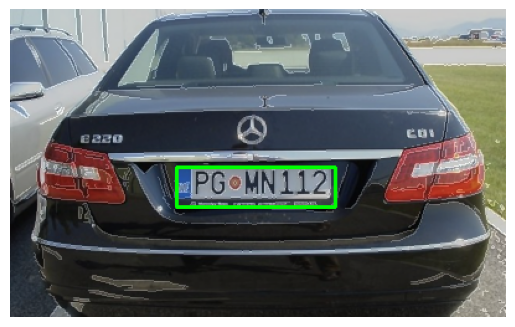

In [ ]:
image_dir = 'datasets/cars_license_plates/train/images'
label_dir = 'datasets/cars_license_plates/train/labels'

image_files = sorted(os.listdir(image_dir))
first_image_file = image_files[0]

# Construct paths for image and its label
image_path = os.path.join(image_dir, first_image_file)
label_path = os.path.join(label_dir, os.path.splitext(first_image_file)[0] + '.txt')

image = cv2.imread(image_path)

# Convert img BGR to OpenCV
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)


with open(label_path, 'r') as f:
    lines = f.readlines()


for line in lines:

    class_id, x_center, y_center, width, height = map(float, line.strip().split())
    img_height, img_width, _ = image.shape

    # Convert YOLO format to bounding box format
    x_center *= img_width
    y_center *= img_height
    width *= img_width
    height *= img_height

    x1 = int(x_center - width / 2)
    y1 = int(y_center - height / 2)
    x2 = int(x_center + width / 2)
    y2 = int(y_center + height / 2)

    cv2.rectangle(image, (x1, y1), (x2, y2), (0, 255, 0), 2)


plt.imshow(image)
plt.axis('off')
plt.show()

In [ ]:
datasets_yaml = '''
path: cars_license_plate_new

train: train/images
val: val/images
test: test/images

# number of classes
nc: 1

# class names
names: ['license_plate']
'''

# Write the content to the datasets.yaml file
with open('datasets.yaml', 'w') as file:
    file.write(datasets_yaml)

# Using YOLOv8 nano model

In [ ]:
# using YOLOv8 nano
from ultralytics import YOLO
model = YOLO('yolov8n.pt')

In [ ]:
os.environ['WANDB_MODE'] = 'offline'

In [ ]:
def train_with_preprocessing(model, train_data):
    def preprocessed_dataset(data):
        for batch in data:
            yield [preprocess_image(img) for img in batch]

    results = model.train(data=preprocessed_dataset(train_data), epochs=100, imgsz=640)

In [ ]:
model.train(
    data='datasets.yaml',
    epochs=100,
    batch=16,
    device='cuda',
    imgsz=320,  # Image size (width and height) for training
    cache=True
)

Ultralytics YOLOv8.2.92 🚀 Python-3.10.12 torch-2.4.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=yolov8n.pt, data=datasets.yaml, epochs=100, time=None, patience=100, batch=16, imgsz=320, save=True, save_period=-1, cache=True, device=cuda, workers=8, project=None, name=train3, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, show_boxes=True, 

train: Scanning /content/datasets/cars_license_plate_new/train/labels.cache... 345 images, 0 backgrounds, 0 corrupt: 100%|██████████| 345/345 [00:00<?, ?it/s]


WARNING ⚠️ cache='ram' may produce non-deterministic training results. Consider cache='disk' as a deterministic alternative if your disk space allows.


train: Caching images (0.1GB RAM): 100%|██████████| 345/345 [00:04<00:00, 73.34it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
val: Scanning /content/datasets/cars_license_plate_new/val/labels.cache... 44 images, 0 backgrounds, 0 corrupt: 100%|██████████| 44/44 [00:00<?, ?it/s]


WARNING ⚠️ cache='ram' may produce non-deterministic training results. Consider cache='disk' as a deterministic alternative if your disk space allows.


val: Caching images (0.0GB RAM): 100%|██████████| 44/44 [00:00<00:00, 53.16it/s]


Plotting labels to runs/detect/train3/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 320 train, 320 val
Using 2 dataloader workers
Logging results to runs/detect/train3
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/100     0.751G      3.995       5.28      2.681         18        320: 100%|██████████| 22/22 [00:04<00:00,  4.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  9.48it/s]

                   all         44         44   0.000535      0.136   0.000339   8.52e-05



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/100     0.661G      3.492       4.35      2.137          9        320: 100%|██████████| 22/22 [00:04<00:00,  4.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  9.06it/s]

                   all         44         44   0.000229     0.0455   0.000135   2.11e-05



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/100     0.631G      3.462      3.882      2.056         10        320: 100%|██████████| 22/22 [00:02<00:00,  7.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  8.48it/s]

                   all         44         44   0.000427      0.114    0.00035   0.000103



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/100     0.617G      3.357      3.781      2.044          9        320: 100%|██████████| 22/22 [00:02<00:00,  8.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  8.59it/s]

                   all         44         44   0.000303     0.0909   0.000187   4.95e-05



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/100     0.619G      3.388      3.761      2.048         16        320: 100%|██████████| 22/22 [00:03<00:00,  5.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.23it/s]

                   all         44         44   0.000152     0.0455   9.63e-05   1.93e-05



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/100     0.619G      3.436      3.726      2.073          9        320: 100%|██████████| 22/22 [00:09<00:00,  2.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.46it/s]

                   all         44         44   0.000851      0.136   0.000403   0.000101



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/100     0.617G      3.406      3.591      1.995         14        320: 100%|██████████| 22/22 [00:02<00:00,  7.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.01it/s]

                   all         44         44   0.000387     0.0227   0.000438   4.38e-05



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/100     0.617G      3.267      3.559      2.002         10        320: 100%|██████████| 22/22 [00:02<00:00,  8.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  8.37it/s]

                   all         44         44    0.00141      0.114    0.00058   0.000131



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/100     0.617G      3.322      3.473      1.956         11        320: 100%|██████████| 22/22 [00:02<00:00,  7.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.11it/s]

                   all         44         44   0.000696     0.0227   0.000201   4.86e-05



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/100     0.619G      3.186      3.297      2.027         17        320: 100%|██████████| 22/22 [00:04<00:00,  4.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.63it/s]

                   all         44         44    0.00341     0.0227     0.0019    0.00037



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/100     0.619G      3.284      3.429       1.92         12        320: 100%|██████████| 22/22 [00:04<00:00,  4.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.56it/s]

                   all         44         44   0.000989      0.295   0.000835   0.000253



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/100     0.619G      3.247      3.289        1.9          8        320: 100%|██████████| 22/22 [00:02<00:00,  7.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  9.35it/s]

                   all         44         44   0.000791      0.227   0.000956   0.000288



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/100     0.617G      3.131      3.219      1.966         11        320: 100%|██████████| 22/22 [00:04<00:00,  5.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.44it/s]

                   all         44         44      0.206     0.0455     0.0139    0.00416



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/100     0.619G      2.974       3.03      1.883         11        320: 100%|██████████| 22/22 [00:05<00:00,  4.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.25it/s]

                   all         44         44     0.0137     0.0455    0.00326   0.000716



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/100     0.619G      3.031      3.071      1.858         13        320: 100%|██████████| 22/22 [00:05<00:00,  4.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.63it/s]

                   all         44         44      0.355     0.0227     0.0145    0.00451



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/100     0.619G       2.94      3.026      1.861         15        320: 100%|██████████| 22/22 [00:04<00:00,  4.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  8.83it/s]

                   all         44         44     0.0996     0.0227     0.0172    0.00217



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/100     0.617G      3.003      2.999      1.884         13        320: 100%|██████████| 22/22 [00:02<00:00,  7.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  9.88it/s]

                   all         44         44   0.000871      0.136    0.00154   0.000356



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/100     0.617G      3.072      3.001      1.864         12        320: 100%|██████████| 22/22 [00:02<00:00,  8.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  8.65it/s]

                   all         44         44      0.036     0.0227      0.011    0.00352



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/100     0.617G      2.986       2.77      1.831         13        320: 100%|██████████| 22/22 [00:03<00:00,  6.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.47it/s]

                   all         44         44    0.00686      0.114    0.00399   0.000721



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/100     0.619G      2.911       2.82      1.855          9        320: 100%|██████████| 22/22 [00:04<00:00,  4.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.94it/s]

                   all         44         44     0.0514     0.0227     0.0104    0.00334



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/100     0.619G      2.836      2.932      1.831         13        320: 100%|██████████| 22/22 [00:04<00:00,  5.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  9.63it/s]

                   all         44         44     0.0601     0.0227    0.00656    0.00141



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/100     0.619G      2.845       2.82      1.776         14        320: 100%|██████████| 22/22 [00:02<00:00,  7.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  9.72it/s]

                   all         44         44      0.013     0.0455    0.00766    0.00201



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/100     0.619G      2.748      2.699      1.777         16        320: 100%|██████████| 22/22 [00:02<00:00,  7.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  8.32it/s]

                   all         44         44     0.0178     0.0909     0.0135    0.00473



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/100     0.617G      2.706      2.536      1.734          7        320: 100%|██████████| 22/22 [00:03<00:00,  5.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.26it/s]

                   all         44         44     0.0012      0.205    0.00129   0.000286



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/100     0.619G      2.834      2.689      1.797         12        320: 100%|██████████| 22/22 [00:04<00:00,  4.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.46it/s]

                   all         44         44     0.0511     0.0227     0.0138    0.00288



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/100     0.617G      2.652      2.645      1.724         13        320: 100%|██████████| 22/22 [00:03<00:00,  5.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  9.32it/s]

                   all         44         44     0.0739     0.0682     0.0131    0.00352



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/100     0.619G      2.589      2.482      1.666         13        320: 100%|██████████| 22/22 [00:02<00:00,  7.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  9.64it/s]

                   all         44         44      0.239     0.0682     0.0534     0.0216



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/100     0.617G      2.624      2.522      1.686         12        320: 100%|██████████| 22/22 [00:02<00:00,  7.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  9.28it/s]

                   all         44         44      0.283     0.0455     0.0427     0.0147



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/100     0.619G      2.533      2.374      1.648         11        320: 100%|██████████| 22/22 [00:04<00:00,  5.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.56it/s]

                   all         44         44      0.289      0.159     0.0768     0.0233



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/100     0.619G      2.507      2.356      1.657         13        320: 100%|██████████| 22/22 [00:04<00:00,  4.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.87it/s]

                   all         44         44      0.204      0.114     0.0674     0.0223



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/100     0.617G      2.373      2.362      1.616         20        320: 100%|██████████| 22/22 [00:02<00:00,  7.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  9.55it/s]

                   all         44         44      0.537      0.114      0.109      0.022



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/100     0.617G      2.595      2.405      1.628         12        320: 100%|██████████| 22/22 [00:02<00:00,  7.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  8.88it/s]

                   all         44         44      0.266      0.114     0.0601     0.0135



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/100     0.617G      2.394      2.188      1.595         11        320: 100%|██████████| 22/22 [00:03<00:00,  7.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.40it/s]

                   all         44         44      0.403     0.0909      0.104     0.0336



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/100     0.617G      2.493      2.291      1.658         14        320: 100%|██████████| 22/22 [00:04<00:00,  4.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.66it/s]

                   all         44         44      0.907     0.0909      0.122      0.049



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/100     0.617G      2.474      2.217      1.652         14        320: 100%|██████████| 22/22 [00:04<00:00,  5.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  8.89it/s]

                   all         44         44      0.554      0.113      0.104     0.0403



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/100     0.617G      2.319      2.076      1.579          9        320: 100%|██████████| 22/22 [00:02<00:00,  7.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  9.04it/s]

                   all         44         44      0.168      0.159     0.0591     0.0222



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/100     0.617G      2.301      2.153      1.556         15        320: 100%|██████████| 22/22 [00:02<00:00,  7.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  9.10it/s]

                   all         44         44      0.432      0.182      0.145     0.0651



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/100     0.619G      2.233      1.961      1.553         10        320: 100%|██████████| 22/22 [00:04<00:00,  5.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.08it/s]

                   all         44         44      0.475      0.159       0.13     0.0462



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/100     0.619G      2.269       2.04      1.561          9        320: 100%|██████████| 22/22 [00:04<00:00,  4.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.60it/s]

                   all         44         44      0.226      0.136      0.116     0.0317



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/100     0.619G      2.195      2.021      1.517         16        320: 100%|██████████| 22/22 [00:03<00:00,  7.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  9.03it/s]

                   all         44         44      0.579      0.159      0.169     0.0473



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/100     0.617G      2.183      1.973      1.551         10        320: 100%|██████████| 22/22 [00:03<00:00,  6.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.97it/s]

                   all         44         44      0.643      0.136      0.142     0.0504



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/100     0.617G      2.205      1.925      1.493         11        320: 100%|██████████| 22/22 [00:05<00:00,  4.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.92it/s]

                   all         44         44      0.471      0.162      0.166     0.0651



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/100     0.617G      2.262      2.006      1.537         21        320: 100%|██████████| 22/22 [00:05<00:00,  4.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.16it/s]

                   all         44         44      0.889      0.159      0.179     0.0727



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/100     0.619G      2.177      1.941      1.508         10        320: 100%|██████████| 22/22 [00:04<00:00,  5.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  9.27it/s]

                   all         44         44      0.476      0.205      0.177     0.0678



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/100     0.619G      2.159       1.92      1.497         11        320: 100%|██████████| 22/22 [00:02<00:00,  7.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  8.78it/s]

                   all         44         44      0.497      0.182      0.162      0.056



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/100     0.619G      2.096      1.842      1.491         14        320: 100%|██████████| 22/22 [00:02<00:00,  7.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  9.43it/s]

                   all         44         44      0.656      0.114      0.133     0.0357



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/100     0.619G      2.071      1.823      1.465         11        320: 100%|██████████| 22/22 [00:03<00:00,  5.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.20it/s]

                   all         44         44      0.603      0.205      0.181     0.0425



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/100     0.617G       2.02      1.709      1.436         16        320: 100%|██████████| 22/22 [00:04<00:00,  4.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.78it/s]

                   all         44         44      0.613      0.159       0.17     0.0582



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/100     0.619G      2.064      1.775      1.418         18        320: 100%|██████████| 22/22 [00:03<00:00,  7.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.90it/s]

                   all         44         44      0.618      0.159      0.172     0.0773



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/100     0.617G      2.022      1.681      1.417         13        320: 100%|██████████| 22/22 [00:02<00:00,  7.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  9.15it/s]

                   all         44         44      0.624      0.159      0.161     0.0822



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/100     0.617G      2.035      1.706       1.47         12        320: 100%|██████████| 22/22 [00:02<00:00,  8.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  9.57it/s]

                   all         44         44      0.725       0.18      0.193     0.0645



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/100     0.619G      2.041      1.702      1.401         12        320: 100%|██████████| 22/22 [00:04<00:00,  4.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.79it/s]

                   all         44         44      0.739      0.205       0.21     0.0796



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/100     0.619G       1.91      1.612      1.406         14        320: 100%|██████████| 22/22 [00:04<00:00,  4.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  8.76it/s]

                   all         44         44      0.482      0.227      0.204      0.101



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/100     0.617G      1.944      1.629      1.401         15        320: 100%|██████████| 22/22 [00:02<00:00,  7.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  8.66it/s]

                   all         44         44      0.391      0.182      0.178     0.0886



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/100     0.617G      1.951      1.668      1.432         11        320: 100%|██████████| 22/22 [00:02<00:00,  8.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  9.35it/s]

                   all         44         44        0.7      0.182      0.192     0.0926



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/100     0.619G      1.878      1.653      1.302         13        320: 100%|██████████| 22/22 [00:03<00:00,  6.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.34it/s]

                   all         44         44      0.791      0.182      0.188     0.0907



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/100     0.619G      1.936      1.581      1.344         19        320: 100%|██████████| 22/22 [00:04<00:00,  4.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.69it/s]

                   all         44         44      0.821      0.182      0.194     0.0951



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/100     0.617G      1.772      1.523      1.371         16        320: 100%|██████████| 22/22 [00:04<00:00,  4.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.20it/s]

                   all         44         44       0.86      0.205      0.211      0.106



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/100     0.617G      1.823      1.514      1.329         12        320: 100%|██████████| 22/22 [00:04<00:00,  4.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.97it/s]

                   all         44         44       0.72      0.205      0.207     0.0967



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/100     0.619G      1.868      1.475      1.344         12        320: 100%|██████████| 22/22 [00:03<00:00,  5.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.02it/s]

                   all         44         44      0.955      0.205      0.229      0.107



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/100     0.619G      1.865      1.489       1.33         18        320: 100%|██████████| 22/22 [00:04<00:00,  4.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.87it/s]

                   all         44         44      0.967      0.205      0.225      0.105



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/100     0.617G      1.737      1.409      1.302          9        320: 100%|██████████| 22/22 [00:03<00:00,  7.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  8.85it/s]

                   all         44         44      0.703      0.216      0.225      0.102



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/100     0.617G      1.787      1.476      1.357         15        320: 100%|██████████| 22/22 [00:02<00:00,  7.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  9.77it/s]

                   all         44         44      0.605      0.227      0.208      0.106



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/100     0.617G      1.824      1.456      1.318         15        320: 100%|██████████| 22/22 [00:02<00:00,  7.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  8.71it/s]

                   all         44         44      0.588      0.227      0.212      0.108



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/100     0.619G      1.697      1.333      1.285         12        320: 100%|██████████| 22/22 [00:04<00:00,  4.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.68it/s]

                   all         44         44      0.834      0.205      0.224      0.112



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/100     0.617G      1.749      1.425      1.308         19        320: 100%|██████████| 22/22 [00:04<00:00,  4.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  9.69it/s]

                   all         44         44      0.796      0.205      0.215     0.0927



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/100     0.619G      1.661      1.342      1.232          9        320: 100%|██████████| 22/22 [00:02<00:00,  7.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  9.19it/s]

                   all         44         44       0.88      0.205      0.225       0.11



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/100     0.619G      1.755       1.43      1.319         11        320: 100%|██████████| 22/22 [00:02<00:00,  7.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  9.19it/s]

                   all         44         44      0.979      0.205      0.229      0.115



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/100     0.617G      1.712      1.364      1.259         10        320: 100%|██████████| 22/22 [00:03<00:00,  6.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.82it/s]

                   all         44         44      0.967      0.205      0.229      0.109



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/100     0.617G      1.665      1.314      1.236          9        320: 100%|██████████| 22/22 [00:04<00:00,  4.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.89it/s]

                   all         44         44          1      0.205      0.223      0.112



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/100     0.617G      1.772      1.374      1.261         18        320: 100%|██████████| 22/22 [00:03<00:00,  5.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  9.57it/s]

                   all         44         44      0.968      0.205      0.229      0.121



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/100     0.619G      1.616      1.255      1.241          9        320: 100%|██████████| 22/22 [00:02<00:00,  8.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  9.13it/s]

                   all         44         44      0.703      0.227      0.236      0.105



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/100     0.619G      1.643      1.325       1.28         17        320: 100%|██████████| 22/22 [00:02<00:00,  8.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  8.88it/s]

                   all         44         44      0.953      0.227      0.239     0.0997



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/100     0.617G      1.622      1.277       1.23         12        320: 100%|██████████| 22/22 [00:03<00:00,  5.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.70it/s]

                   all         44         44      0.979      0.205       0.23     0.0991



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/100     0.617G      1.657       1.28      1.247          8        320: 100%|██████████| 22/22 [00:04<00:00,  4.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.22it/s]

                   all         44         44      0.944      0.205      0.225      0.102



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/100     0.619G      1.581      1.207      1.223         15        320: 100%|██████████| 22/22 [00:02<00:00,  7.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  9.87it/s]

                   all         44         44      0.972      0.205       0.23      0.119



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/100     0.619G      1.529      1.194      1.208         12        320: 100%|██████████| 22/22 [00:02<00:00,  8.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  9.74it/s]

                   all         44         44      0.967      0.205      0.227      0.112



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/100     0.617G      1.622      1.285      1.238          9        320: 100%|██████████| 22/22 [00:02<00:00,  7.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.12it/s]

                   all         44         44      0.946      0.205      0.224      0.112



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/100     0.617G      1.597      1.235      1.214         10        320: 100%|██████████| 22/22 [00:04<00:00,  4.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.72it/s]

                   all         44         44      0.961      0.205      0.225      0.125



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/100     0.617G      1.512      1.169       1.19         10        320: 100%|██████████| 22/22 [00:04<00:00,  5.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  9.46it/s]

                   all         44         44      0.713       0.25      0.236       0.13



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/100     0.617G      1.577      1.215      1.193          9        320: 100%|██████████| 22/22 [00:02<00:00,  8.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  9.55it/s]

                   all         44         44      0.675      0.236       0.24      0.111



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/100     0.617G      1.517      1.155       1.22         14        320: 100%|██████████| 22/22 [00:02<00:00,  7.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  9.15it/s]

                   all         44         44      0.807      0.227      0.247      0.117



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/100     0.617G      1.551      1.213      1.247         12        320: 100%|██████████| 22/22 [00:03<00:00,  5.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.33it/s]

                   all         44         44      0.942      0.227       0.25      0.127



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/100     0.617G      1.434      1.101      1.148         21        320: 100%|██████████| 22/22 [00:04<00:00,  4.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.82it/s]

                   all         44         44      0.915      0.245       0.25      0.121



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/100     0.617G      1.487      1.194      1.187         15        320: 100%|██████████| 22/22 [00:03<00:00,  6.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  9.57it/s]

                   all         44         44      0.955       0.25      0.256       0.13



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/100     0.619G       1.47      1.132      1.159         14        320: 100%|██████████| 22/22 [00:02<00:00,  8.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  9.75it/s]

                   all         44         44      0.669       0.25      0.252      0.125



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/100     0.619G      1.463      1.164      1.154         14        320: 100%|██████████| 22/22 [00:02<00:00,  8.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  9.90it/s]

                   all         44         44      0.562       0.25      0.246      0.121



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/100     0.617G      1.504      1.144      1.186         13        320: 100%|██████████| 22/22 [00:03<00:00,  5.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.02it/s]

                   all         44         44       0.84       0.25      0.256      0.128



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/100     0.619G      1.418      1.081      1.175         14        320: 100%|██████████| 22/22 [00:04<00:00,  4.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.14it/s]

                   all         44         44      0.795       0.25      0.257       0.13



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/100     0.617G      1.556      1.174      1.184         11        320: 100%|██████████| 22/22 [00:05<00:00,  4.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.13it/s]

                   all         44         44      0.814       0.25      0.257      0.125


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/100     0.638G      1.937      1.712      1.453          8        320: 100%|██████████| 22/22 [00:04<00:00,  5.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  9.58it/s]

                   all         44         44      0.804       0.25      0.244      0.123



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/100     0.619G      1.932      1.728       1.46          9        320: 100%|██████████| 22/22 [00:03<00:00,  5.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.50it/s]

                   all         44         44      0.778      0.239      0.242      0.113



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/100     0.617G      1.942      1.715      1.491          9        320: 100%|██████████| 22/22 [00:04<00:00,  4.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.72it/s]

                   all         44         44      0.733       0.25      0.247      0.123



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/100     0.619G      1.924      1.661      1.481          9        320: 100%|██████████| 22/22 [00:03<00:00,  6.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  9.64it/s]

                   all         44         44      0.632       0.25      0.253      0.125



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/100     0.619G      1.911      1.606      1.524          8        320: 100%|██████████| 22/22 [00:02<00:00,  7.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  9.74it/s]

                   all         44         44      0.908      0.226      0.256      0.122



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/100     0.617G      1.931      1.623      1.464          9        320: 100%|██████████| 22/22 [00:02<00:00,  8.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  9.20it/s]

                   all         44         44      0.623      0.263       0.26      0.125



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/100     0.617G      1.838      1.524        1.4          9        320: 100%|██████████| 22/22 [00:03<00:00,  5.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.33it/s]

                   all         44         44      0.626      0.273       0.26      0.124



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/100     0.619G      1.827      1.658      1.438          9        320: 100%|██████████| 22/22 [00:04<00:00,  4.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.71it/s]

                   all         44         44      0.646      0.273      0.262      0.126



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/100     0.617G      1.865      1.536      1.423          9        320: 100%|██████████| 22/22 [00:02<00:00,  7.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  8.19it/s]

                   all         44         44        0.7      0.273      0.262      0.128



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/100     0.617G      1.791      1.515      1.398          9        320: 100%|██████████| 22/22 [00:02<00:00,  7.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  9.18it/s]

                   all         44         44      0.746      0.267      0.263      0.133



100 epochs completed in 0.138 hours.
Optimizer stripped from runs/detect/train3/weights/last.pt, 6.2MB
Optimizer stripped from runs/detect/train3/weights/best.pt, 6.2MB

Validating runs/detect/train3/weights/best.pt...
Ultralytics YOLOv8.2.92 🚀 Python-3.10.12 torch-2.4.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 168 layers, 3,005,843 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.59it/s]


                   all         44         44      0.746      0.267      0.263      0.129
Speed: 0.1ms preprocess, 1.6ms inference, 0.0ms loss, 1.4ms postprocess per image
Results saved to runs/detect/train3


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7e4411342b30>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.048048, 

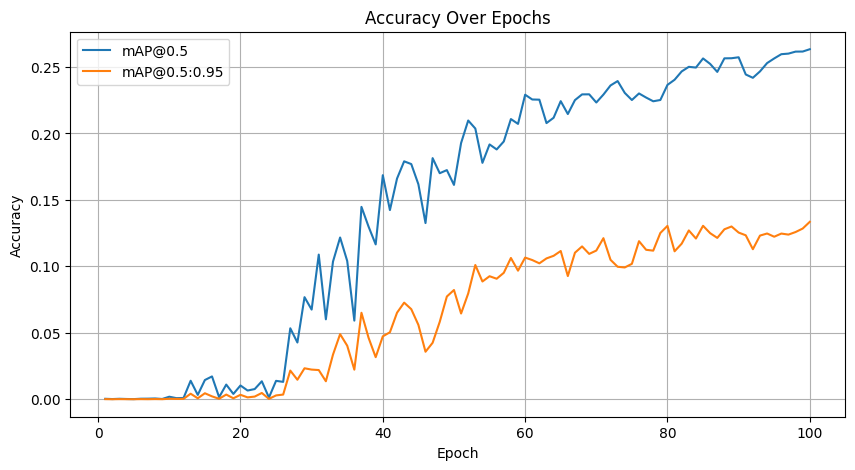

In [ ]:
# Find recent training log dir
log_dir = max(glob('runs/detect/train*'), key=extract_number_from_str)

results = pd.read_csv(os.path.join(log_dir, 'results.csv'))
results.columns = results.columns.str.strip()

epochs = results.index + 1
mAP_0_5 = results['metrics/mAP50(B)']
mAP_0_5_0_95 = results['metrics/mAP50-95(B)']

plt.figure(figsize=(10, 5))
plt.plot(epochs, mAP_0_5, label='mAP@0.5')
plt.plot(epochs, mAP_0_5_0_95, label='mAP@0.5:0.95')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy Over Epochs')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# save model
model.save('anpr-v1.pt')

# Test and predictions

In [ ]:
# to predict test image
def predict_and_plot(path_test_car):

    results = model.predict(path_test_car, device='cpu')


    image = cv2.imread(path_test_car)

    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)


    for result in results:
        for box in result.boxes:

            x1, y1, x2, y2 = map(int, box.xyxy[0])
            confidence = box.conf[0]

            cv2.rectangle(image, (x1, y1), (x2, y2), (0, 255, 0), 2)

            cv2.putText(image, f'{confidence*100:.2f}%', (x1, y1 - 10),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.9, (255, 0, 0), 2)


    plt.imshow(image)
    plt.axis('off')
    plt.show()


image 1/1 /content/dataset/preprocessed_images/Cars425.png: 160x320 (no detections), 48.4ms
Speed: 1.1ms preprocess, 48.4ms inference, 0.7ms postprocess per image at shape (1, 3, 160, 320)


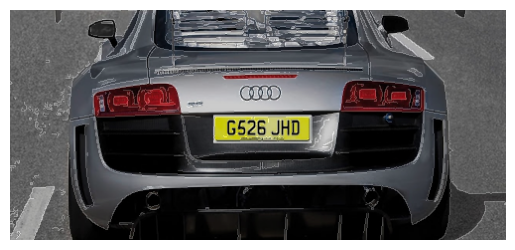

In [ ]:
predict_and_plot(test.iloc[0].img_path)


image 1/1 /content/dataset/preprocessed_images/Cars181.png: 320x192 (no detections), 77.3ms
Speed: 1.0ms preprocess, 77.3ms inference, 0.6ms postprocess per image at shape (1, 3, 320, 192)


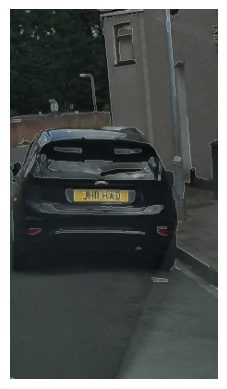

In [ ]:
predict_and_plot(test.iloc[2].img_path)